First we would load the image list from the json file

In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import  Image, ImageDraw
from sklearn.neighbors import KernelDensity
import cv2

In [15]:
json_file = open(r'E:\Semester_Projects\BnF-jadis.github.io-master\assets\data\df_website.json', "r", encoding="utf-8")
image_list = json.load(json_file)
json_file.close()

new_string = json.dumps(image_list, indent=2, ensure_ascii=False)

arks = []
urls = []
titles = []
dates = []
geolocalisations = []

for item in image_list:
    arks.append(item["ark"])
    titles.append(item["title"])
    dates.append(item["date"])
    geolocalisations.append(item["geolocalisation"])
    

Here would be the histogram of the dates of the maps we have, printed is the year with the most maps in the dataset

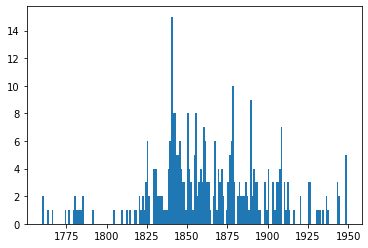

1840


In [16]:
year_duration = list(range(np.min(dates), np.max(dates)+1))
hist_returned = plt.hist(dates, bins=year_duration)
plt.show()
print(hist_returned[1][np.argmax(hist_returned[0])])

Selected the maps for a specific year

In [17]:
selected_year = [1839, 1840, 1841, 1842]
selected_maps = []
selected_map_data = []
for i in range(len(titles)):
    if dates[i] in selected_year:
        selected_maps.append(image_list[i])
        ark = arks[i]
        file_path = r'E:\Semester_Projects\BnF-jadis.github.io-master\export\vectorized\{}f1.json'.format(ark)
        json_file = open(file_path)
        selected_map_data.append(json.load(json_file))
        json_file.close()
print("Number of selcted maps is", len(selected_maps))

Number of selcted maps is 37


Find out thr range of the latitudes and longitudes of the selecteed maps

In [18]:
latitudes = []
longitudes = []
for i in range(len(selected_maps)):
    geolocalisation = selected_maps[i]["geolocalisation"]
    for i in range(4):
        latitudes.append(geolocalisation[i][0])
        longitudes.append(geolocalisation[i][1])
        
latitude_span = max(latitudes)-min(latitudes)
longtitue_span = max(longitudes)-min(longitudes)
print(max(latitudes), min(latitudes), max(longitudes), min(longitudes))
print(latitude_span, longtitue_span)

48.89784689855318 48.80414667129867 2.433331648036194 2.2543690372328737
0.09370022725451577 0.1789626108033202


Define the function to transfer the latitudes and longitudes

In [19]:
def transfer(lontitude, latitude, canvas_size):
    max_latitudes = max(latitudes)
    min_longitudes = min(longitudes)
    # print(max_latitudes, min_longitudes)
    transfered_latitude = (max_latitudes - latitude) / longtitue_span * canvas_size / np.cos(np.deg2rad(48.51))
    transfered_lontitude = (lontitude - min_longitudes) / longtitue_span * canvas_size
    # print(transfered_latitude, transfered_lontitude)
    return int(transfered_lontitude), int(transfered_latitude)

Drawing the map

In [20]:
canvas_size = 10000

canvas = np.zeros((canvas_size, canvas_size)).astype('uint8')

maps = []
mapA = canvas

print("Drawing map")
for i, map_data in enumerate(selected_map_data):
    print(i, end=" ")
    img = Image.fromarray(canvas)
    draw = ImageDraw.Draw(img)
    for vector in map_data:
        draw.line(np.ravel([transfer(
            y, x, canvas_size) for (x, y) in vector]).tolist(), fill=1)
    current_map = np.array(img)
    
    dilated = cv2.dilate(current_map * 255,(7,7))
    blured = cv2.blur(dilated,(3,3))
    
    normalized = blured / np.max(blured)
    
    maps.append(current_map)    
    mapA = current_map + mapA

print("\nThe shape of mapA is ", mapA.shape)
print("The maximum of mapA is, ", np.max(mapA))

Drawing map
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
The shape of mapA is  (10000, 10000)
The maximum of mapA is,  10


In [31]:
def blur(img):
    dilated = cv2.dilate(img * 255,(7,7))
    blured = cv2.blur(dilated,(6,6))
    return blured

def dilate(img):
    dilated = cv2.dilate(img * 255,(10,10))
    return dilated

In [22]:
selected_maps[0]["date"]
selected_maps[0]["ark"]
selected_maps[0]["title"]

'Nouveau plan routier de la ville de Paris'

In [26]:
Image.fromarray(blur(mapA) > 0)

In [24]:
im1 = maps[0]
im2 = maps[1]

# Find size of image1
sz = im1.shape

# Define the motion model
warp_mode = cv2.MOTION_TRANSLATION

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 5000;
    
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;
    
# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1,im2,warp_matrix, warp_mode, criteria)


if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);


In [33]:
Image.fromarray(blur(im1 + im2_aligned) > 0)

Select the interested region of the map

In [13]:
latitude_range = [48.833, 48.873]
longitude_range = [2.303, 2.384]

x_min, y_min  = transfer(longitude_range[0], latitude_range[1], canvas_size)
x_max, y_max  = transfer(longitude_range[1], latitude_range[0], canvas_size)
print(x_min, x_max)
print(y_min, y_max)

mapB = mapA[y_min:y_max, x_min:x_max]
print("The shape of mapB is ", np.shape(mapB))
print("The maximum of mapB is ", np.max(mapB))


2717 7243
2095 5469
The shape of mapB is  (3374, 4526)
The maximum of mapB is  10


In [20]:
Image.fromarray(mapA > 0)

In [16]:
Image.fromarray(mapA > 0)